In [21]:
import numpy as np
import rasterio
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [22]:
# Load the predictor variables
with rasterio.open(r'data\aggregated_over_years_model_input\sm_min_pro.tif') as src:
    sm_min = src.read(1)  # Read the first band

with rasterio.open(r'data\aggregated_over_years_model_input\lai_min_pro.tif') as src:
    lai_min = src.read(1)  # Read the first band

with rasterio.open(r'data\aggregated_over_years_model_input\lai_sum_mean_pro.tif') as src:
    lai_sum_mean = src.read(1)  # Read the first band

with rasterio.open(r'data\aggregated_over_years_model_input\t_max_pro.tif') as src:
    t_max = src.read(1)  # Read the first band

with rasterio.open(r'data\aggregated_over_years_model_input\index_max_pro.tif') as src:
    index_max = src.read(1)  # Read the first band

with rasterio.open(r'data\aggregated_over_years_model_input\index_severity_pro.tif') as src:
    index_severity = src.read(1)  # Read the first band

with rasterio.open(r'data\aggregated_over_years_model_input\index_len_pro.tif') as src:
    index_len = src.read(1)  # Read the first band


# Load the response variable
with rasterio.open(r'data\dead\deadwood.tif') as src:
    deadwood = src.read(1)  # Read the first band

In [23]:
# Flatten the arrays to 1D
sm_min_flat = sm_min.flatten()
lai_min_flat = lai_min.flatten()
lai_sum_mean_flat = lai_sum_mean.flatten()
t_max_flat = t_max.flatten()
index_max_flat = index_max.flatten()
index_severity_flat = index_severity.flatten()
index_len_flat = index_len.flatten()
deadwood_flat = deadwood.flatten()


# Stack predictor variables into a single array
# X = np.column_stack((sm_min_flat, lai_min_flat, lai_sum_mean_flat, t_max_flat, index_max_flat, index_severity_flat, index_len_flat))
X = np.column_stack((sm_min_flat, lai_min_flat, lai_sum_mean_flat, t_max_flat))

y = deadwood_flat

# Remove rows with NAs and entries with -32768.0 in deadwood_flat
mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y) & (y != -32768.0)
X_clean = X[mask]
y_clean = y[mask]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=400)


In [16]:
# Use GridsearchCV for this
param_grid = {
    'ccp_alpha': [0.01, 0.1, 0.5, 1.0],  # Vary the complexity parameter (cp)
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features' : ['sqrt', 'log2'], #The number of features to consider when looking for the best split:
    'n_estimators' :  [5, 100, 1000, 1500, 2000] # numbers of trees in a forest
}


# Create the model
rf = RandomForestRegressor(random_state=123, oob_score=True )


# Perform grid search with cross-validation
grid_search = GridSearchCV(rf, param_grid, cv = 5, scoring = 'neg_mean_squared_error', verbose=2, n_jobs=-1 ) #set by default for classification

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits
Best parameters: {'ccp_alpha': 0.01, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 2000}


In [24]:
# Print the best parameters
print("Best parameters:", grid_search.best_params_)

best_rf = grid_search.best_estimator_
oob_score = best_rf.oob_score_

print("OOB Score of the best model:", oob_score)

Best parameters: {'ccp_alpha': 0.01, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 2000}
OOB Score of the best model: 0.62698639617107


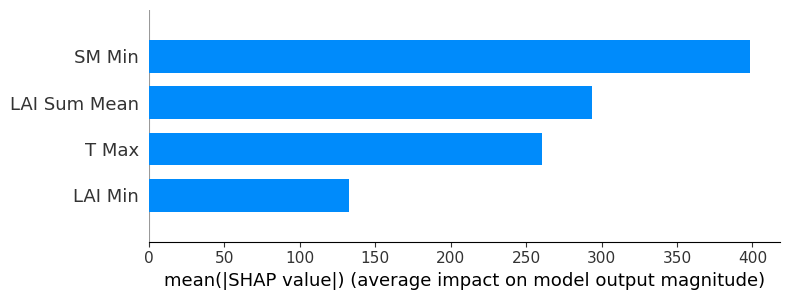

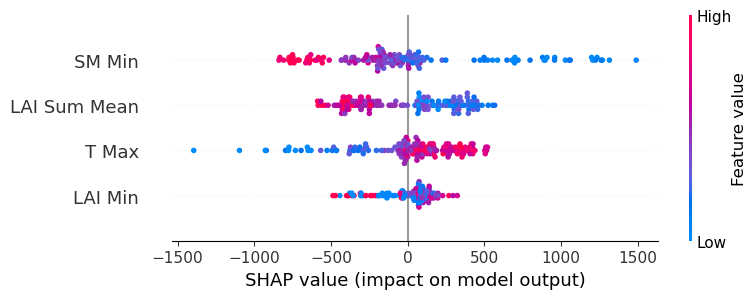

In [20]:
# Retrieve the best estimator from the grid search
best_rf = grid_search.best_estimator_

# Initialize SHAP Explainer for the best model
explainer = shap.TreeExplainer(best_rf)

# Compute SHAP values for the training set
shap_values = explainer.shap_values(X_train)

# Define custom feature names
feature_names = ['SM Min', 'LAI Min', 'LAI Sum Mean', 'T Max']

# Plot global feature importance with custom feature names
shap.summary_plot(shap_values, X_train, plot_type="bar", feature_names=feature_names)

# Detailed dot plot for all features with custom feature names
shap.summary_plot(shap_values, X_train, plot_type='dot', feature_names=feature_names)


# colinearity / correlation

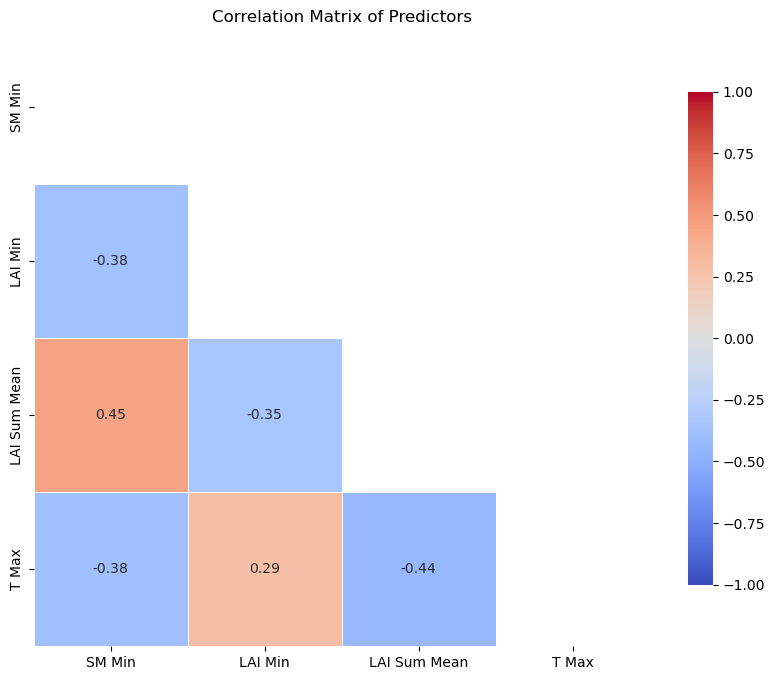

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming X_clean is a numpy array with your cleaned predictors
# Create a DataFrame for better handling with columns named according to your predictors
df_predictors = pd.DataFrame(X_clean, columns=['SM Min', 'LAI Min', 'LAI Sum Mean', 'T Max'])

# Compute the correlation matrix
corr_matrix = df_predictors.corr()

# Generate a mask for the upper triangle (optional, for aesthetics)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', 
            vmax=1, vmin=-1, square=True, linewidths=.5, cbar_kws={"shrink": .8})

# Add titles and labels for clarity
plt.title('Correlation Matrix of Predictors')
plt.show()


# prediction

In [26]:
# Making predictions
predictions = best_rf.predict(X_clean)


full_predictions = np.full(sm_min.shape, np.nan)  # Fill the array with np.nan
# 'mask' is the same mask used earlier to filter X and y
full_predictions[mask.reshape(sm_min.shape)] = predictions


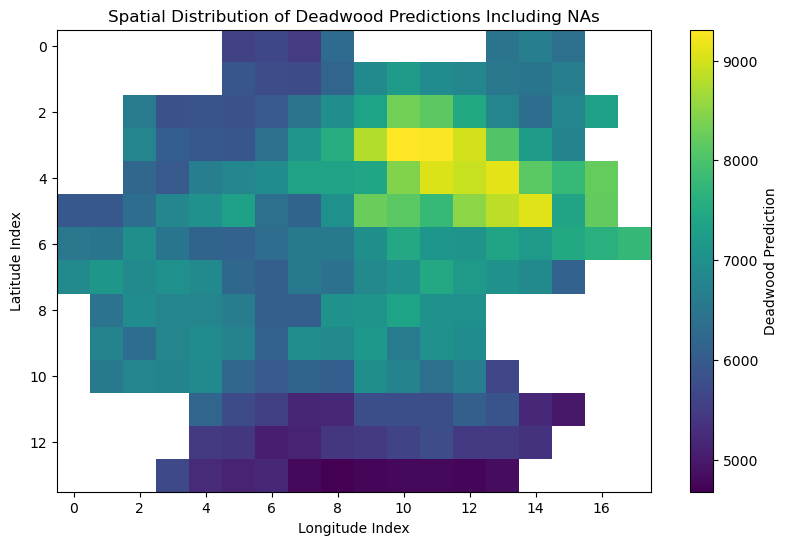

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.imshow(full_predictions, cmap='viridis')
plt.colorbar(label='Deadwood Prediction')
plt.title('Spatial Distribution of Deadwood Predictions Including NAs')
plt.xlabel('Longitude Index')
plt.ylabel('Latitude Index')
plt.show()


# checking for colinearity:  running the random forest model many times with randomly selected subsets of predictors

In [ ]:
# Flatten the arrays to 1D
sm_min_flat = sm_min.flatten()
lai_min_flat = lai_min.flatten()
lai_sum_mean_flat = lai_sum_mean.flatten()
t_max_flat = t_max.flatten()
index_max_flat = index_max.flatten()
index_severity_flat = index_severity.flatten()
index_len_flat = index_len.flatten()
deadwood_flat = deadwood.flatten()


# Stack predictor variables into a single array
# X = np.column_stack((sm_min_flat, lai_min_flat, lai_sum_mean_flat, t_max_flat, index_max_flat, index_severity_flat, index_len_flat))
X = np.column_stack((sm_min_flat, lai_min_flat, lai_sum_mean_flat, t_max_flat))

y = deadwood_flat

# Remove rows with NAs and entries with -32768.0 in deadwood_flat
mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y) & (y != -32768.0)
X_clean = X[mask]
y_clean = y[mask]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=400)

In [ ]:
rf = RandomForestRegressor(random_state=123, oob_score=True )
# Best parameters: {'ccp_alpha': 0.01, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 2000}
